c:\Users\lewa\Anaconda3\envs\py310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>


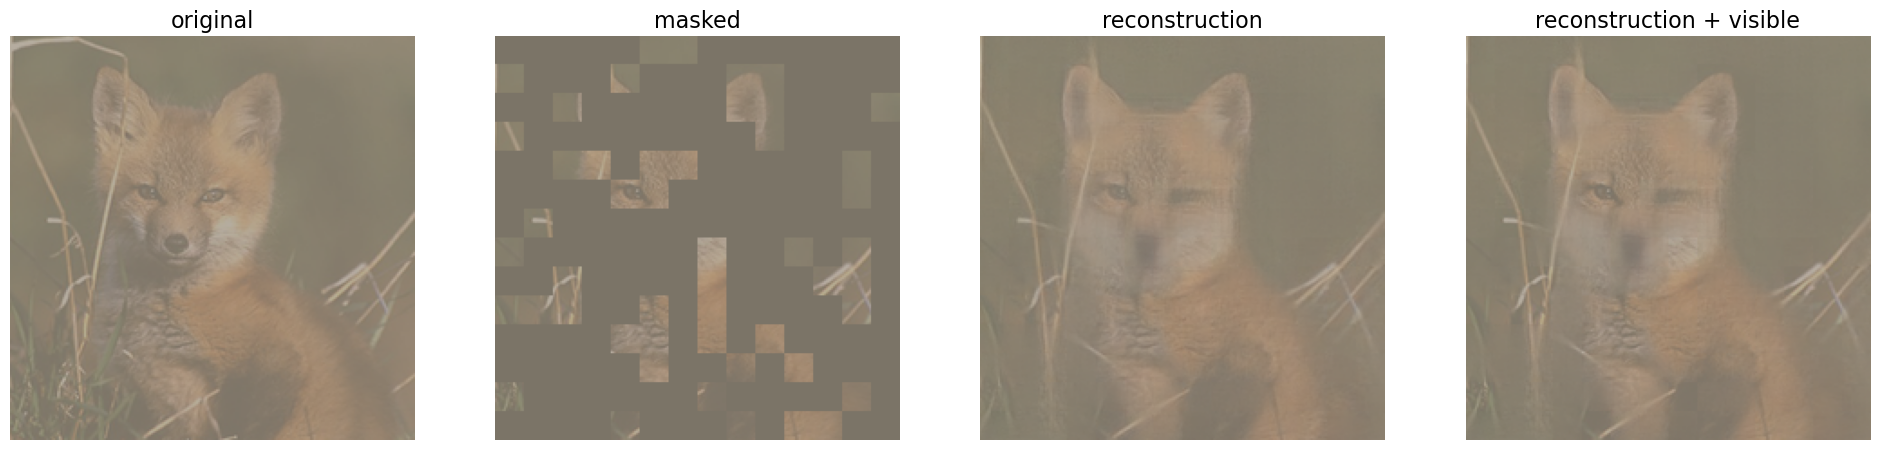

In [1]:
import torch
import sys
sys.path.append('C:/Users/lewa/Documents/PhD/vit/vit-pytorch/')
sys.path.append('C:/Users/lewa/Documents/PhD/vit/mae/')
import models_mae
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
#autoreload python file
%reload_ext autoreload
%autoreload 2

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model


def show_image(image, title=''):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])  
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return
def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

chkpt_dir = 'C:/Users/lewa/Documents/PhD/Models/mae_visualize_vit_large_ganloss.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

run_one_image(img, model_mae)

<All keys matched successfully>


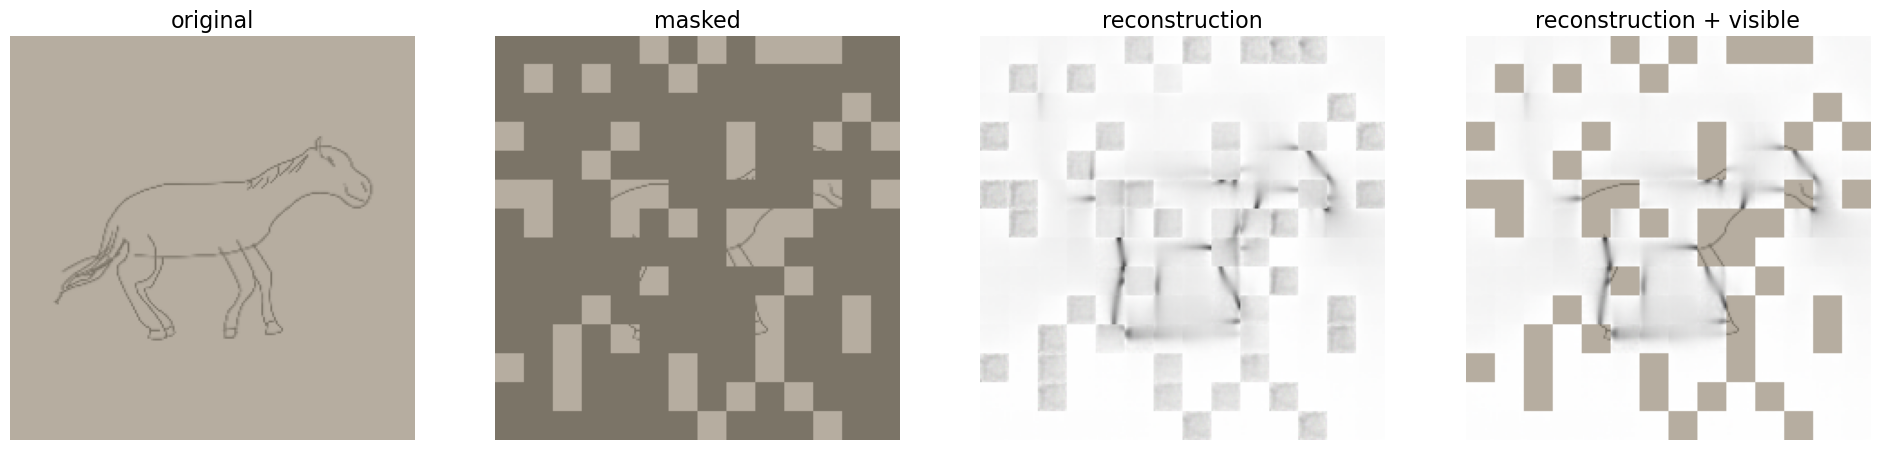

In [8]:
chkpt_dir = 'C:/Users/lewa/Documents/PhD/Models/sketch/sketch.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
img_url = 'https://pic2.zhimg.com/80/v2-638f7800c7ba3c03d4dc4541c4938961_1440w.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = Image.open('../../dataset/PACS/kfold/sketch/horse/8484.png')
img = img.resize((224, 224))
img = np.array(img) / 255.

run_one_image(img, model_mae)

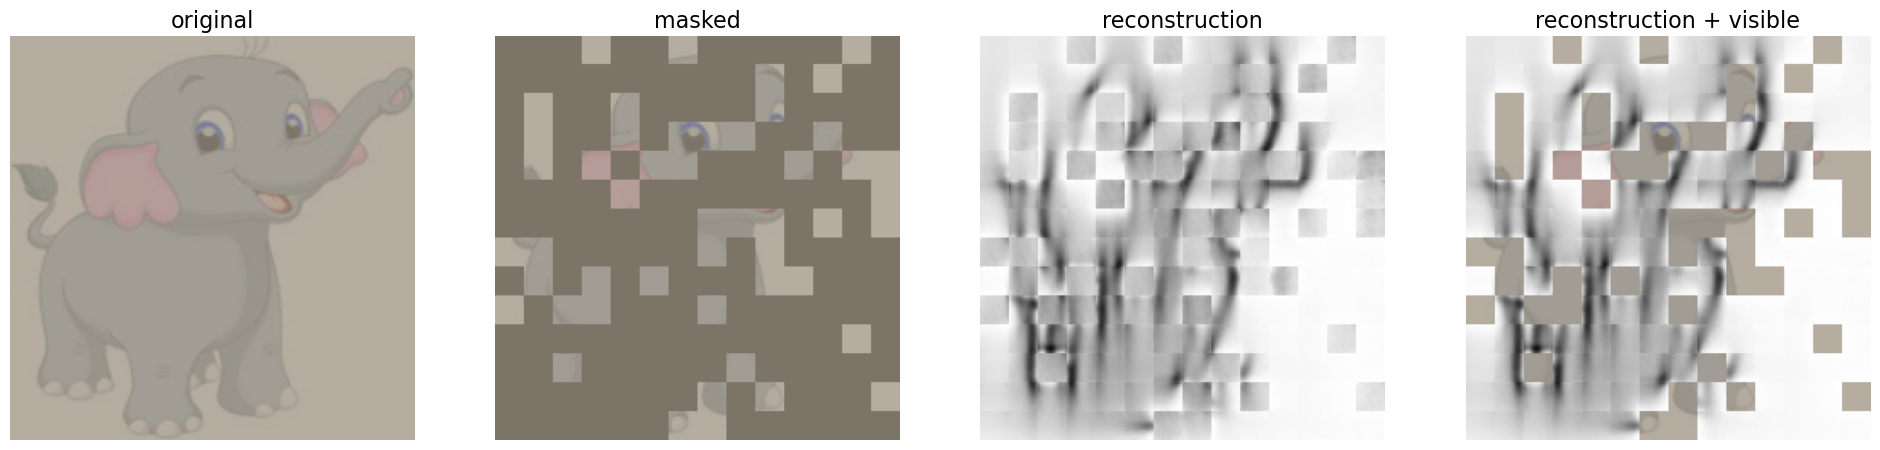

In [11]:
img = Image.open('../../dataset/PACS/kfold/cartoon/elephant/pic_002.jpg')
img = img.resize((224, 224))
img = np.array(img) / 255.
run_one_image(img, model_mae)

SystemExit: 

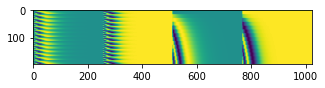

In [20]:
plt.figure(figsize=(5,5))
x = torch.tensor(img)
# make it a batch-like
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x)
loss, y, mask = model_mae(x.float(), mask_ratio=0.75)

In [8]:
mask.shape

torch.Size([1, 196])

In [2]:
import torch
torch.cuda.is_available()

True

Test

In [16]:
noise = torch.rand(3, 6)
ids_shuffle = torch.argsort(noise, dim=1) 
torch.argsort(ids_shuffle, dim=1)

tensor([[3, 5, 2, 4, 0, 1],
        [3, 5, 1, 4, 2, 0],
        [2, 1, 3, 0, 5, 4]])

Training

In [ ]:
import main_pretrain
main()

In [ ]:
!python .\mae\main_pretrain.py --data_path 'C:/Users/lewa/Documents/PhD/dataset/PACS/kfold/photo' --output_dir 'C:/Users/lewa/Documents/PhD/Models'

python .\mae\main_finetune.py --data_path 'C:/Users/lewa/Documents/PhD/dataset/PACS/kfold/sketch' --output_dir 'C:/Users/lewa/Documents/PhD/Models/sketch' --nb_classes 7 --resume 'C:/Users/lewa/Documents/PhD/Models/sketch/sketch.pth'

In [ ]:
! nvidia-smi

In [7]:
tmp = torch.ones((4,5)).unsqueeze(dim=1)
print(tmp.shape)

torch.Size([4, 1, 5])
